# Setting up

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets, tree
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.random import set_seed

# Import data
from preprocessing import load_bikes_prepr

# Interpretability measures
from interpretability import PDP

import shap

In [ ]:
def find_best_model(model, parameters, X_train, y_train): 
    clf = GridSearchCV(model, parameters, scoring=('neg_root_mean_squared_error'), cv=KFold())
    clf.fit(X_train, y_train)

    return clf

def print_errors(clf, model_name, X_test, y_test):
    y_pred = clf.predict(X_test)
    
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print("RMSE ({}): {}".format(model_name, rmse))
    r2 = r2_score(y_test, y_pred)
    print("R-squared score ({}) : {}".format(model_name, r2))

In [ ]:
X, y, feature_names = load_bikes_prepr()
seed = 3012

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [ ]:
explainers = dict()
models = dict()
shap_values = dict()

# Decision tree regressor

## Training model

In [ ]:
model_name = "decision tree regressor"
parameters = {'criterion': ('squared_error', 'friedman_mse', 'absolute_error', 'poisson')}
# parameters = {'criterion': ('squared_error', 'friedman_mse', 'absolute_error', 'poisson'), 'splitter': ('best', 'random') , 'min_samples_split': np.arange(2, 301)}
tr = tree.DecisionTreeRegressor(random_state=seed)

clf = find_best_model(tr, parameters, X_train, y_train)
print_errors(clf, model_name, X_test, y_test)

model = clf.best_estimator_
models[model_name] = model
model

RMSE (decision tree regressor): 58.94590711387484
R-squared score (decision tree regressor) : 0.892936277909009


DecisionTreeRegressor(random_state=3012)

## Intrinsic interpretability

<AxesSubplot:>

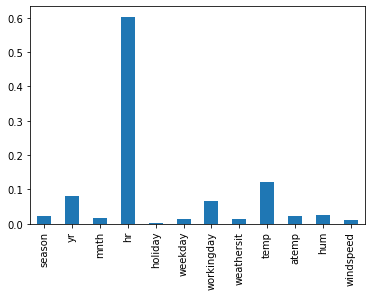

In [ ]:
df = pd.Series(data=model.feature_importances_, index=feature_names)
df.plot.bar()

## Partial dependence plot

In [ ]:
print(feature_names)

Index(['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed'],
      dtype='object')


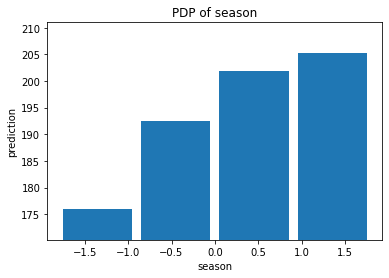

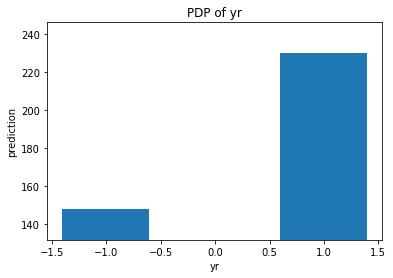

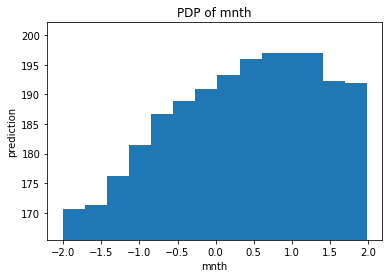

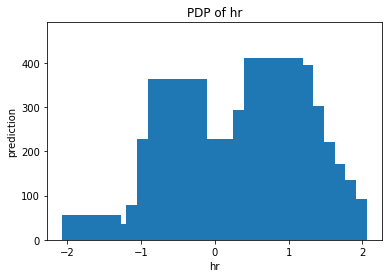

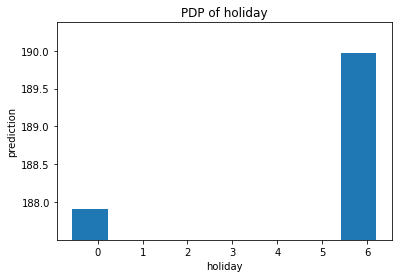

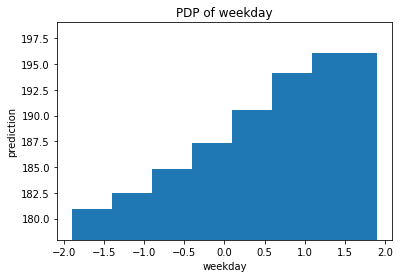

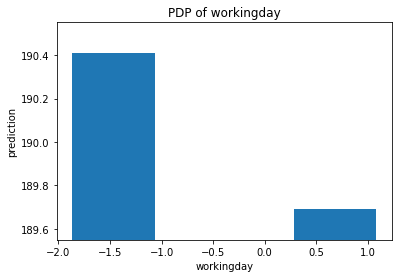

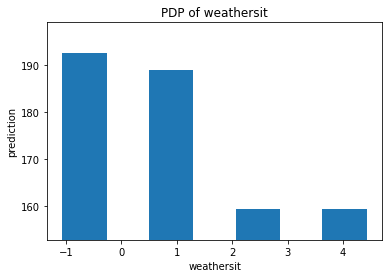

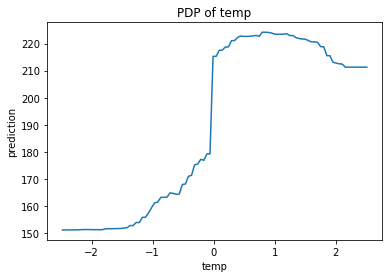

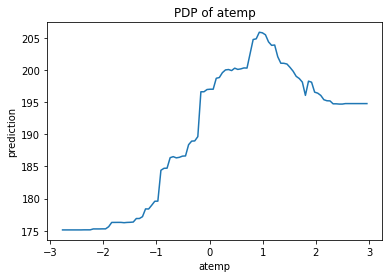

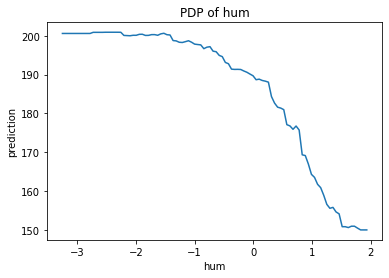

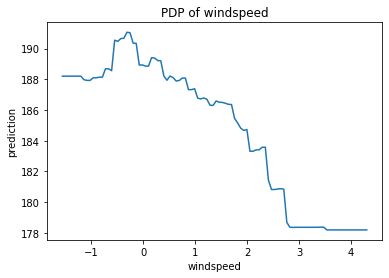

In [ ]:
categorical = [True, True, True, True, True, True, True, True, False, False, False, False]

for i in range(X_test.shape[1]):
    PDP(i, feature_names[i], model, X_test, y_test, categorical=categorical[i])
    plt.show()
    plt.close()

### SHAP

In [ ]:
### Make seperate plot for each one, and also one with all the shaps combined (can be used later in the report)
idx = 4

X_test_df = pd.DataFrame(X_test, columns=feature_names)

explainers[model_name] = shap.KernelExplainer(model.predict, shap.sample(X_train, 300))

shap_test = explainers[model_name].shap_values(X_test_df.iloc[idx])

# PLOT SHAPLEY VALUES IN NORMAL WAY

shap.initjs()
shap.force_plot(explainers[model_name].expected_value, shap_test, X_test_df.iloc[idx])
# shap.force_plot(explainer.expected_value[1], shap_test[1], X_test_df.iloc[idx]) # for decision trees

Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [ ]:
shap_values_all = dict()
X_test_df = pd.DataFrame(X_test, columns=feature_names)

explainer = explainers[model_name]
shap_values[model_name] = explainer.shap_values(X_test_df.iloc[:5])
shap_values_all = shap_values[model_name]

  0%|          | 0/5 [00:00<?, ?it/s]

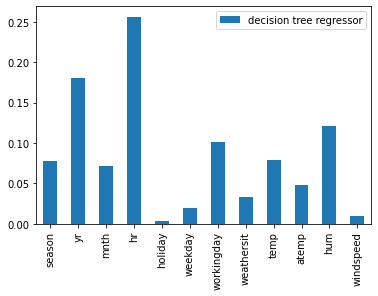

In [ ]:
shapley_feat_imps = pd.DataFrame(index=feature_names)

shap_value = shap_values_all
feat_imps = np.mean(np.abs(shap_value), axis=0)
feat_imps /= np.sum(feat_imps)


shapley_feat_imps.insert(0, model_name, feat_imps)
shapley_feat_imps.plot.bar()
plt.show()

# Linear regression models

## Training model

Lasso and Ridge give the same errors

In [ ]:
model_name = "linear regression"
parameters = {}
linreg = LinearRegression()

clf = find_best_model(linreg, parameters, X_train, y_train)
print_errors(clf, model_name, X_test, y_test)

model = clf.best_estimator_
models[model_name] = model
model

RMSE (linear regression): 140.7242912588483
R-squared score (linear regression) : 0.3897986460392311


LinearRegression()

## Intrinsic interpretability

<AxesSubplot:>

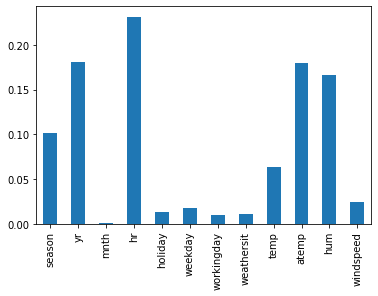

In [ ]:
df = pd.Series(data=np.abs(model.coef_)/np.sum(np.abs(model.coef_)), index=feature_names)
df.plot.bar()

## Partial dependence plot

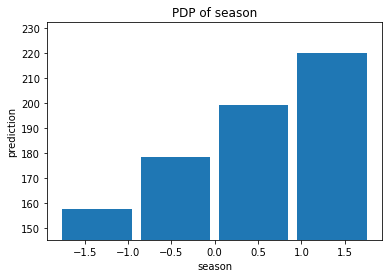

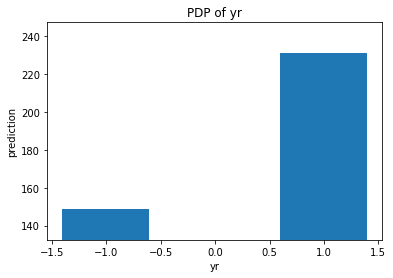

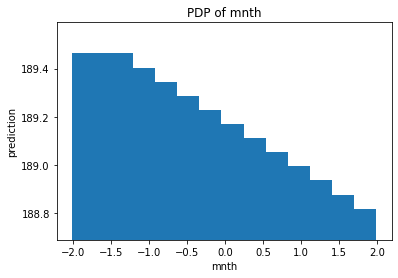

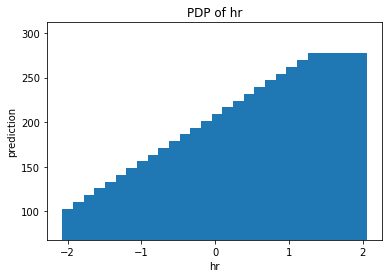

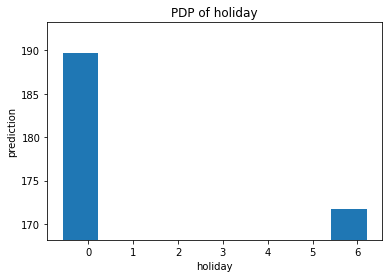

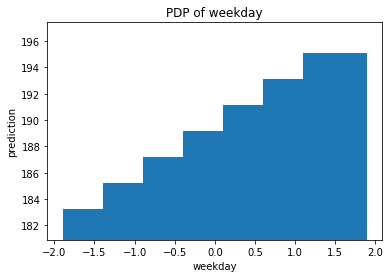

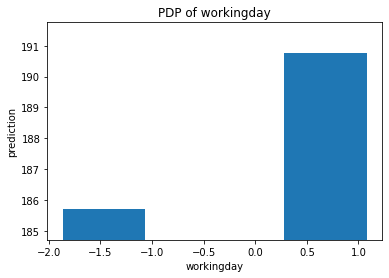

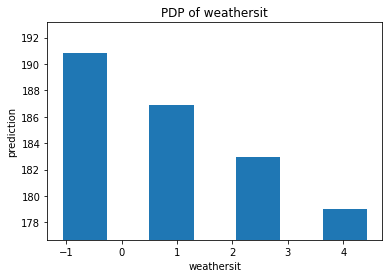

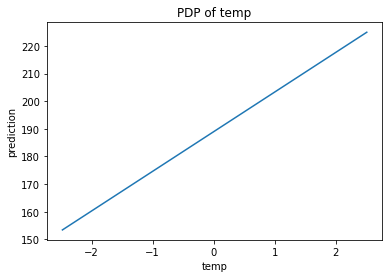

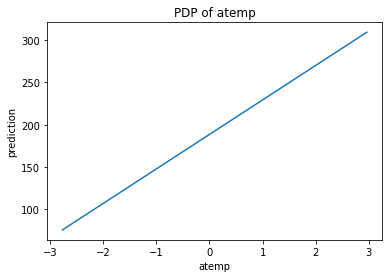

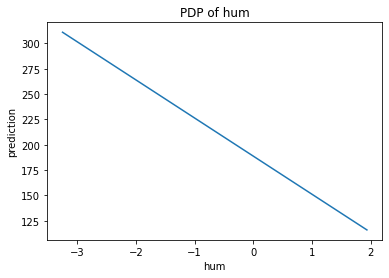

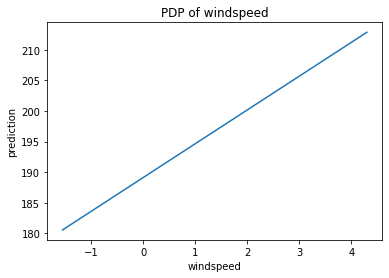

In [ ]:
categorical = [True, True, True, True, True, True, True, True, False, False, False, False]

for i in range(X_test.shape[1]):
    PDP(i, feature_names[i], model, X_test, y_test, categorical=categorical[i])
    plt.show()
    plt.close()

### SHAP

In [ ]:
### Make seperate plot for each one, and also one with all the shaps combined (can be used later in the report)
idx = 4

X_test_df = pd.DataFrame(X_test, columns=feature_names)

explainers[model_name] = shap.KernelExplainer(model.predict, shap.sample(X_train, 300))

shap_test = explainers[model_name].shap_values(X_test_df.iloc[idx])

# PLOT SHAPLEY VALUES IN NORMAL WAY

shap.initjs()
shap.force_plot(explainers[model_name].expected_value, shap_test, X_test_df.iloc[idx])
# shap.force_plot(explainer.expected_value[1], shap_test[1], X_test_df.iloc[idx]) # for decision trees

Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [ ]:
shap_values_all = dict()
X_test_df = pd.DataFrame(X_test, columns=feature_names)

explainer = explainers[model_name]
shap_values[model_name] = explainer.shap_values(X_test_df.iloc[:5])
shap_values_all = shap_values[model_name]

  0%|          | 0/5 [00:00<?, ?it/s]

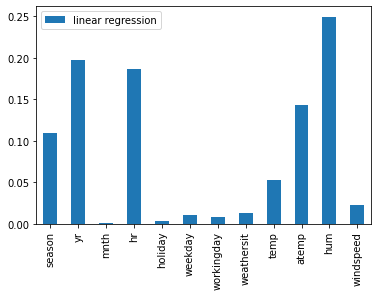

In [ ]:
shapley_feat_imps = pd.DataFrame(index=feature_names)

shap_value = shap_values_all
feat_imps = np.mean(np.abs(shap_value), axis=0)
feat_imps /= np.sum(feat_imps)


shapley_feat_imps.insert(0, model_name, feat_imps)
shapley_feat_imps.plot.bar()
plt.show()

# KNN regressor

## Training model

In [ ]:
print(X_train.shape)

(13903, 12)


In [ ]:
model_name = "k-nearest neighbors"
parameters = {'n_neighbors': np.arange(1, 11, 1), 'weights': ('uniform', 'distance')}
# parameters = {'n_neighbors': np.arange(1, 13903, ), 'weights': ('uniform', 'distance')}
kNN = KNeighborsRegressor()

clf = find_best_model(kNN, parameters, X_train, y_train)
print_errors(clf, model_name, X_test, y_test)

model = clf.best_estimator_
models[model_name] = model
model

RMSE (k-nearest neighbors): 103.1210375516704
R-squared score (k-nearest neighbors) : 0.672335361561309


KNeighborsRegressor(n_neighbors=7, weights='distance')

## Partial dependence plot

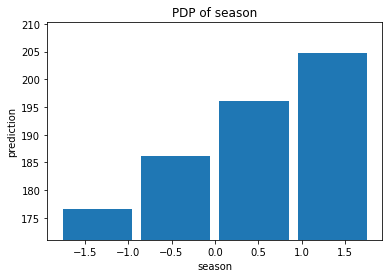

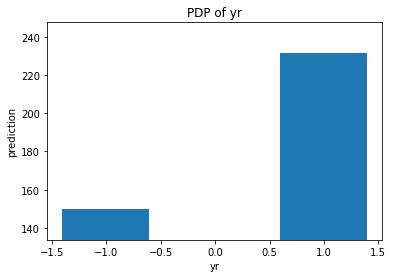

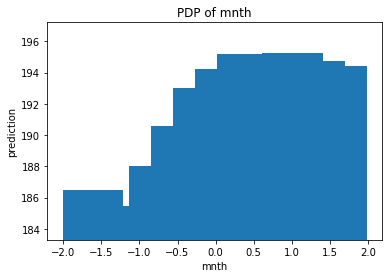

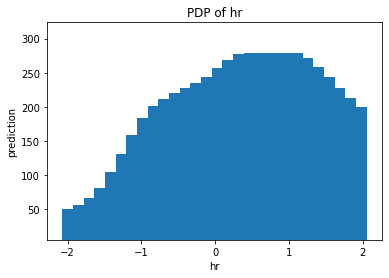

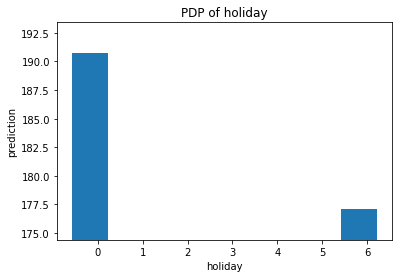

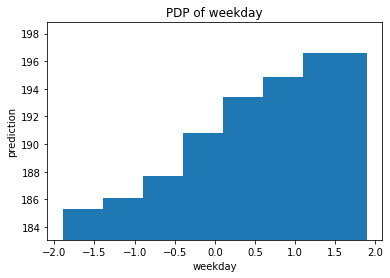

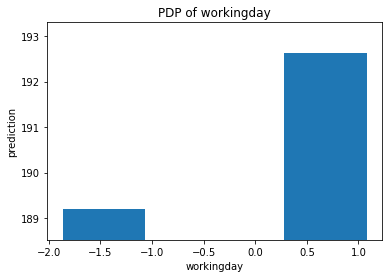

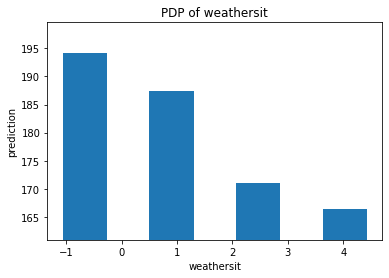

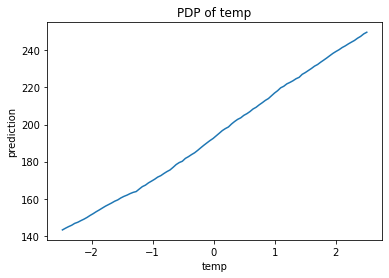

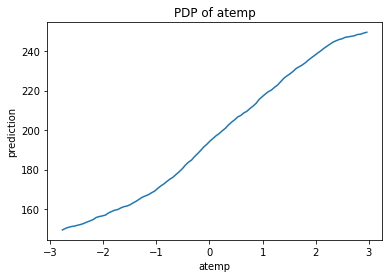

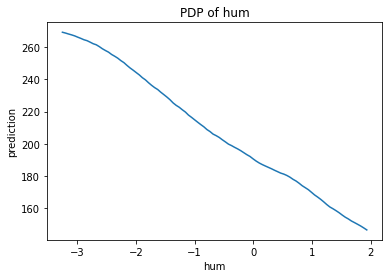

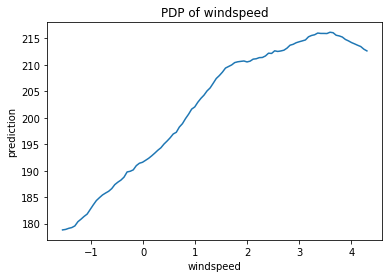

In [ ]:
categorical = [True, True, True, True, True, True, True, True, False, False, False, False]

for i in range(X_test.shape[1]):
    PDP(i, feature_names[i], model, X_test, y_test, categorical=categorical[i])
    plt.show()
    plt.close()

### SHAP

In [ ]:
### Make seperate plot for each one, and also one with all the shaps combined (can be used later in the report)
idx = 4

X_test_df = pd.DataFrame(X_test, columns=feature_names)

explainers[model_name] = shap.KernelExplainer(model.predict, shap.sample(X_train, 300))

shap_test = explainers[model_name].shap_values(X_test_df.iloc[idx])

# PLOT SHAPLEY VALUES IN NORMAL WAY

shap.initjs()
shap.force_plot(explainers[model_name].expected_value, shap_test, X_test_df.iloc[idx])
# shap.force_plot(explainer.expected_value[1], shap_test[1], X_test_df.iloc[idx]) # for decision trees

Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [ ]:
shap_values_all = dict()
X_test_df = pd.DataFrame(X_test, columns=feature_names)

explainer = explainers[model_name]
shap_values[model_name] = explainer.shap_values(X_test_df.iloc[:5])
shap_values_all = shap_values[model_name]

  0%|          | 0/5 [00:00<?, ?it/s]

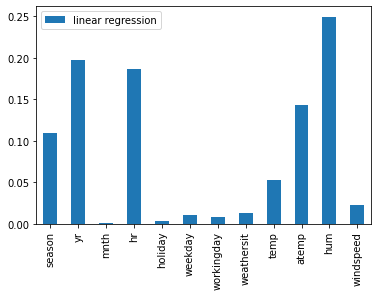

In [ ]:
shapley_feat_imps = pd.DataFrame(index=feature_names)

shap_value = shap_values_all
feat_imps = np.mean(np.abs(shap_value), axis=0)
feat_imps /= np.sum(feat_imps)


shapley_feat_imps.insert(0, model_name, feat_imps)
shapley_feat_imps.plot.bar()
plt.show()

## Neural Network


In [ ]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.2, random_state=seed)

In [ ]:
# Initialise neural network
BATCH_SIZE=64
INPUT_SIZE= X_train.shape[1]

set_seed(seed)

model = Sequential()
model.add(Input(INPUT_SIZE))
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.1))
# model.add(Dense(10, activation="relu"))
# model.add(Dropout(0.1))
model.add(Dense(10, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(optimizer='adam',
                loss="mean_absolute_error",
                metrics=['mean_squared_error'])

n_epochs = 400
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=n_epochs, validation_data=(X_val, y_val)) # validation_split=0.2)

Epoch 1/400
174/174 [==============================] - 1s 3ms/step - loss: 187.5651 - mean_squared_error: 68071.7489 - val_loss: 174.1757 - val_mean_squared_error: 60310.4102
Epoch 2/400
174/174 [==============================] - 0s 2ms/step - loss: 173.5460 - mean_squared_error: 61841.7740 - val_loss: 132.9630 - val_mean_squared_error: 39305.1094
Epoch 3/400
174/174 [==============================] - 0s 1ms/step - loss: 126.7575 - mean_squared_error: 36584.6451 - val_loss: 97.1700 - val_mean_squared_error: 20803.4570
Epoch 4/400
174/174 [==============================] - 0s 2ms/step - loss: 105.3057 - mean_squared_error: 24249.4020 - val_loss: 94.9073 - val_mean_squared_error: 19350.5742
Epoch 5/400
174/174 [==============================] - 0s 1ms/step - loss: 102.0600 - mean_squared_error: 22605.5414 - val_loss: 94.0320 - val_mean_squared_error: 19231.7852
Epoch 6/400
174/174 [==============================] - 0s 1ms/step - loss: 101.4644 - mean_squared_error: 22957.5852 - val_loss:

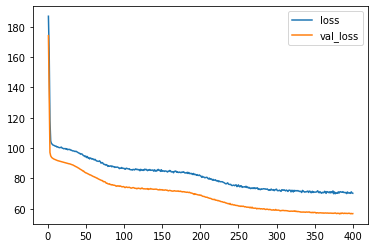

382
(array([382]),)


In [ ]:
for key in ['loss', 'val_loss']:
    plt.plot(np.arange(1, n_epochs+1), history.history[key], label=key)
plt.legend()
plt.show()

print(np.argmin(history.history['val_loss']))
print(np.where(history.history['val_loss'] == np.min(history.history['val_loss'])))

In [ ]:
model_name = "Neural network"
print_errors(model, model_name, X_test, y_test)

RMSE (Neural network): 102.86224258152107
R-squared score (Neural network) : 0.6739779275567881


In [ ]:
models[model_name] = model

In [ ]:
### Make seperate plot for each one, and also one with all the shaps combined (can be used later in the report)
idx = 4
model_name = "Neural network"

X_test_df = pd.DataFrame(X_test, columns=feature_names)

def nn_predict(X):
    y_pred = model.predict(X)
    y_pred = np.reshape(y_pred, X.shape[0])
    return classify(np.array(y_pred))


explainers[model_name] = shap.KernelExplainer(model = model.predict,data=shap.sample(X_train, 300), link="identity")

shap_test = explainers[model_name].shap_values(X_test_df.iloc[idx])

print(shap_test[0])

# PLOT SHAPLEY VALUES IN NORMAL WAY

shap.initjs()
shap.force_plot(explainers[model_name].expected_value, 
    shap_test[0],
     X_test_df.iloc[idx])
# shap.force_plot(explainer.expected_value[1], shap_test[1], X_test_df.iloc[idx]) # for decision trees

Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
[  -5.3678377   -20.89235654    2.16889568 -125.15963309    0.12554772
   -5.69782231   -3.05739026    5.84434611    2.23851604    1.23778926
   -2.0098887     2.01621841]


In [ ]:
shap_values_all = dict()
X_test_df = pd.DataFrame(X_test, columns=feature_names)

explainer = explainers[model_name]
shap_values[model_name] = explainer.shap_values(X_test_df.iloc[:5])
shap_values_all = shap_values[model_name]

  0%|          | 0/5 [00:00<?, ?it/s]

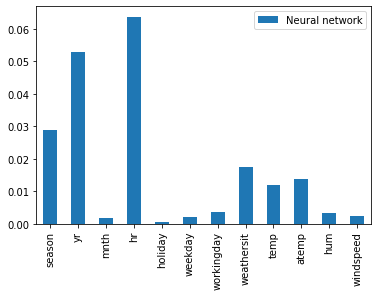

In [ ]:
shapley_feat_imps = pd.DataFrame(index=feature_names)

shap_value = shap_values_all
feat_imps = np.mean(np.abs(shap_value), axis=0)
feat_imps /= np.sum(feat_imps)


shapley_feat_imps.insert(0, model_name, feat_imps[0])
shapley_feat_imps.plot.bar()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=90a57419-7b7b-4aa4-8a97-858f9f98a849' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>